<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-05-18 23:34:44--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>] 352.02K  --.-KB/s    in 0.03s   

2022-05-18 23:34:44 (10.5 MB/s) - ‘train.csv.1’ saved [360467/360467]

--2022-05-18 23:34:44--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: 

In [4]:
!head train.csv

Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,13/03/2012,11:45,216.56,221.92,39.9125,42.415,81.665,113.52,0.0,623.36,1.42625,9690.24,12604.2,95436.8,758.88,48.375,2.0,17.8275
1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.592,11022.0,10787.2,95436.8,762.069,47.808,2.0,18.1207
2,13/03/2012,12:15,219.403,218.933,39.772,42.2267,81.424,113.6,0.0,622.656,1.89133,13960.5,9669.63,95398.6,766.251,47.432,2.0,18.4367
3,13/03/2012,12:30,218.613,217.045,39.776,42.0987,81.5013,113.344,0.0,622.571,1.828,18511.2,9648.13,95360.3,766.037,47.024,2.0,18.7513
4,13/03/2012,12:45,217.714,216.08,39.7757,42.0686,81.4657,113.034,0.0,622.4,2.36071,26349.0,9208.32,9535

In [5]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [6]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 11:45:00', freq='15T'),
 Timestamp('2012-04-11 06:30:00', freq='15T'))

In [7]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2012-03-13 11:45:00 to 2012-04-11 06:30:00
Freq: 15T
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind             

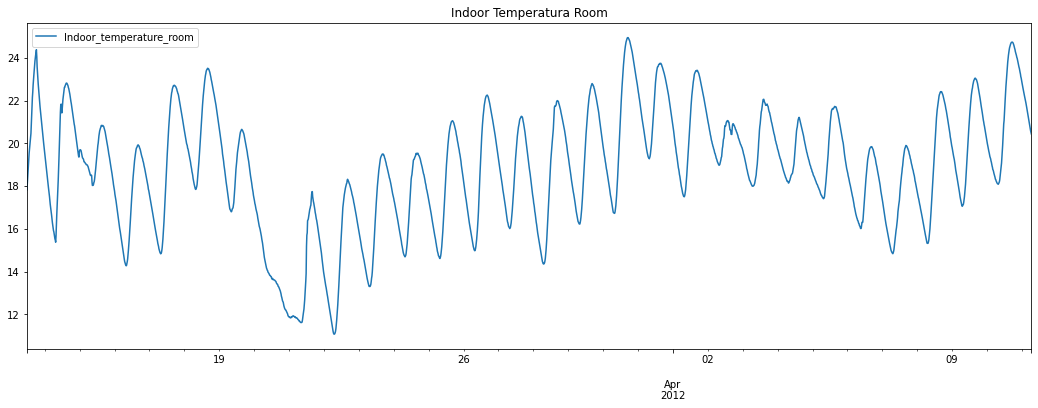

In [16]:
df_treino[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')

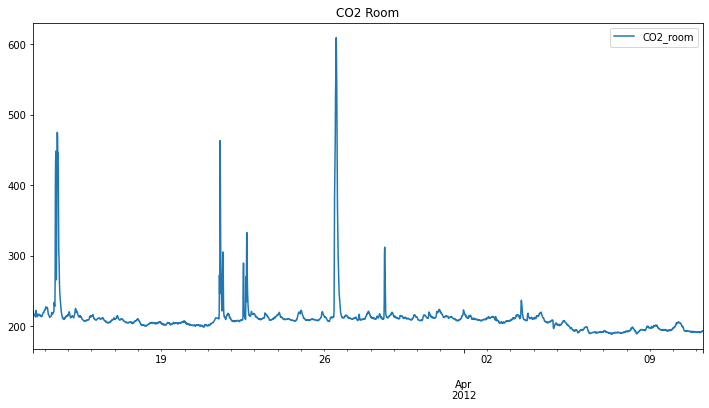

In [9]:
df_treino[['CO2_room']].plot(figsize=(12,6), title='CO2 Room')

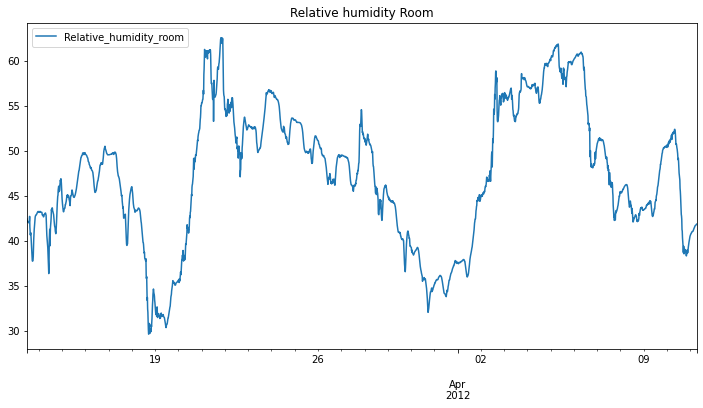

In [10]:
df_treino[['Relative_humidity_room']].plot(figsize=(12,6), title='Relative humidity Room')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


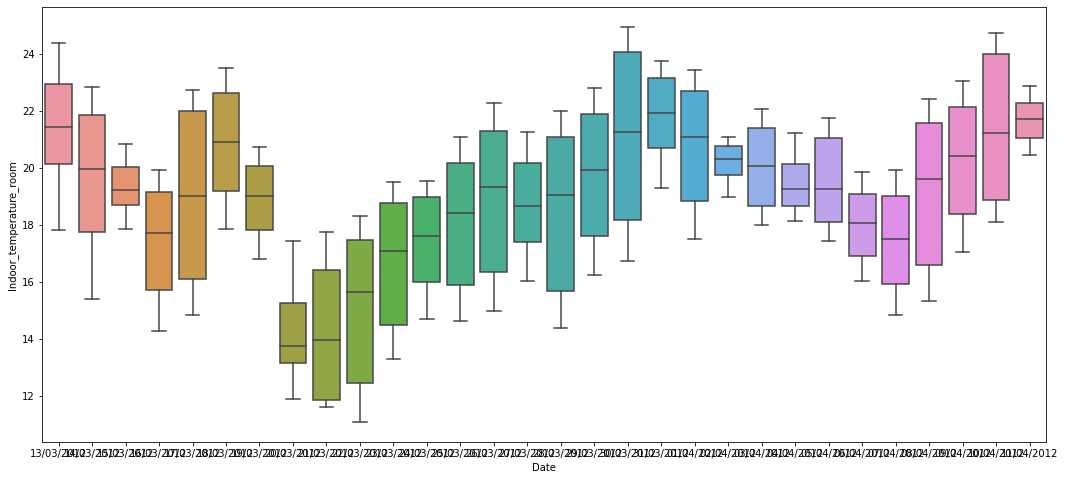

In [11]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(df_treino['Date'],df_treino['Indoor_temperature_room'], ax=ax)

In [12]:
#Teste de Dickey-Fuller para confirmar a (não) estacionariedade
result = adfuller(df_treino['Indoor_temperature_room'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.750770
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


O teste Dickey-Fuller mostrou que a série é estacionária, pois p-value < 0.05. 
Este teste tem H0 como: a série é não estacionária e contém uma raiz unitária. E H1 como: a série é estacionária ou tendência estacionária. Quando o p-value é pequeno, p < 0.05, rejeita-se H0 e portanto há evidências de que a série é estacionária ou tendência-estacionária. Caso p>=0.05, não se rejeita H0 e a série não é estacionária e contém uma raiz unitária.
Contudo observamos nos gráficos de linha e de boxplot por dia que a media, variância e autocovariância não são fixas. 

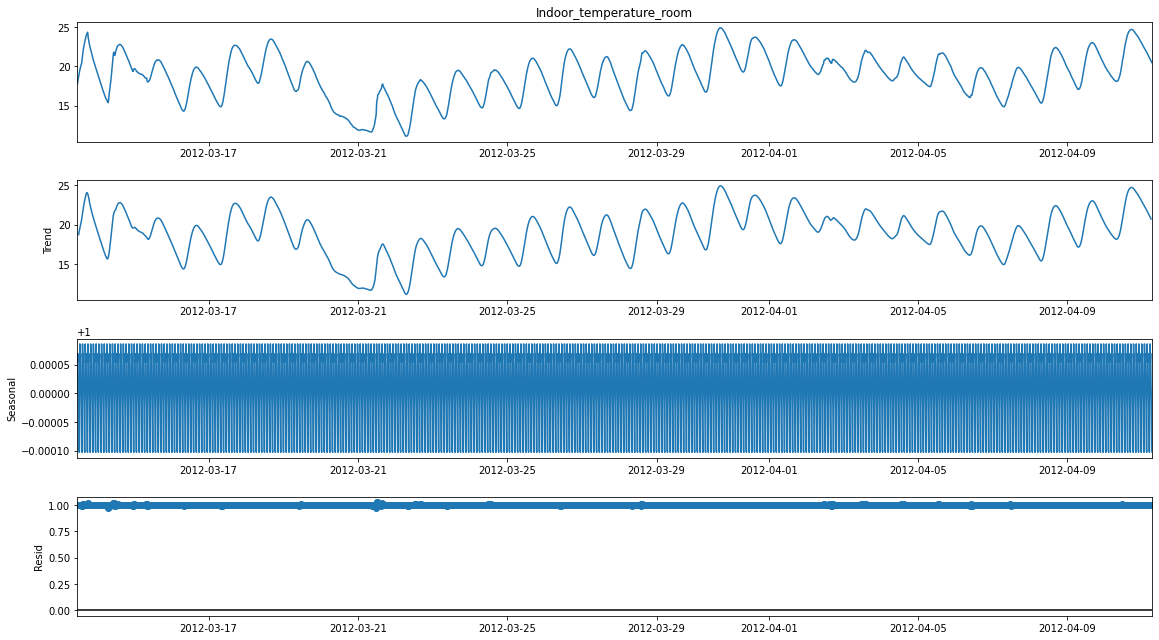

In [19]:
#Decomposição da Indoor_temperature_room em tendência e sazonalidade.
result = seasonal_decompose(df_treino['Indoor_temperature_room'], model='multiplicative', period=7 )
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

NameError: ignored